In [53]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim 
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [54]:
data_dir = r'E:\Samples\CoffeeDisease_Samples'

In [55]:
class_labels = ['Cercospora', 'Coffee Wilt', 'Healthy', 'Leaf Rust', 'Yellow Leaf Disease', 'Green Algae']

In [56]:
# Image pre-process/Image augmentation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [57]:
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0]*len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)


In [58]:
dataset = CoffeeDataset(data_dir, transform=data_transforms)

In [59]:
train_size = int(0.8 * len(dataset))  
val_size = len(dataset) - train_size  
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) 

In [60]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [61]:
print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

Length of training dataset: 817
Length of validation dataset: 205


In [62]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\Nicko/.cache\torch\hub\pytorch_vision_v0.10.0
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [64]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels) 
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [65]:
# Create the CNN model
model = resnet


In [66]:
# Check for available GPUs

device = torch.device("cuda")



In [67]:
# Move the model to the GPU
model = model.to("cuda")


In [68]:
# Get the total number of samples and the number of samples per class
total_samples = 0
samples_per_class = []
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        num_samples = len(os.listdir(class_dir))
        total_samples += num_samples
        samples_per_class.append(num_samples)
        print(f"Number of images in {label}: {num_samples}")

# Calculate the class weights
class_weights = [total_samples / x for x in samples_per_class]
weights = torch.tensor(class_weights).to("cuda")

criterion = nn.BCEWithLogitsLoss(pos_weight=weights.cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001)


Number of images in Cercospora: 601
Number of images in Coffee Wilt: 53
Number of images in Healthy: 160
Number of images in Leaf Rust: 88
Number of images in Yellow Leaf Disease: 76
Number of images in Green Algae: 44


In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(preds, labels):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    precision = precision_score(labels, preds, average=None, zero_division=0)
    recall = recall_score(labels, preds, average=None, zero_division=0)
    f1 = f1_score(labels, preds, average=None, zero_division=0)

    return precision, recall, f1

Epoch 1/32
----------
train Loss: 1.0438 Acc: 0.0734
val Loss: 0.7618 Acc: 0.3171
Epoch 2/32
----------
train Loss: 0.6965 Acc: 0.2815
val Loss: 0.6165 Acc: 0.4488
Epoch 3/32
----------
train Loss: 0.5619 Acc: 0.3905
val Loss: 0.5203 Acc: 0.4439
Epoch 4/32
----------
train Loss: 0.5108 Acc: 0.4174
val Loss: 0.4869 Acc: 0.5317
Epoch 5/32
----------
train Loss: 0.4749 Acc: 0.4835
val Loss: 0.4355 Acc: 0.5415
Epoch 6/32
----------
train Loss: 0.4331 Acc: 0.4969
val Loss: 0.4249 Acc: 0.5707
Epoch 7/32
----------
train Loss: 0.4072 Acc: 0.5006
val Loss: 0.4251 Acc: 0.5854
Early stopping counter: 1 out of 6
Epoch 8/32
----------
train Loss: 0.4095 Acc: 0.5018
val Loss: 0.4188 Acc: 0.6488
Epoch 9/32
----------
train Loss: 0.3939 Acc: 0.5826
val Loss: 0.3955 Acc: 0.5659
Epoch 10/32
----------
train Loss: 0.3719 Acc: 0.5557
val Loss: 0.3920 Acc: 0.5512
Epoch 11/32
----------
train Loss: 0.3922 Acc: 0.5312
val Loss: 0.3422 Acc: 0.5659
Epoch 12/32
----------
train Loss: 0.3614 Acc: 0.5581
val Los

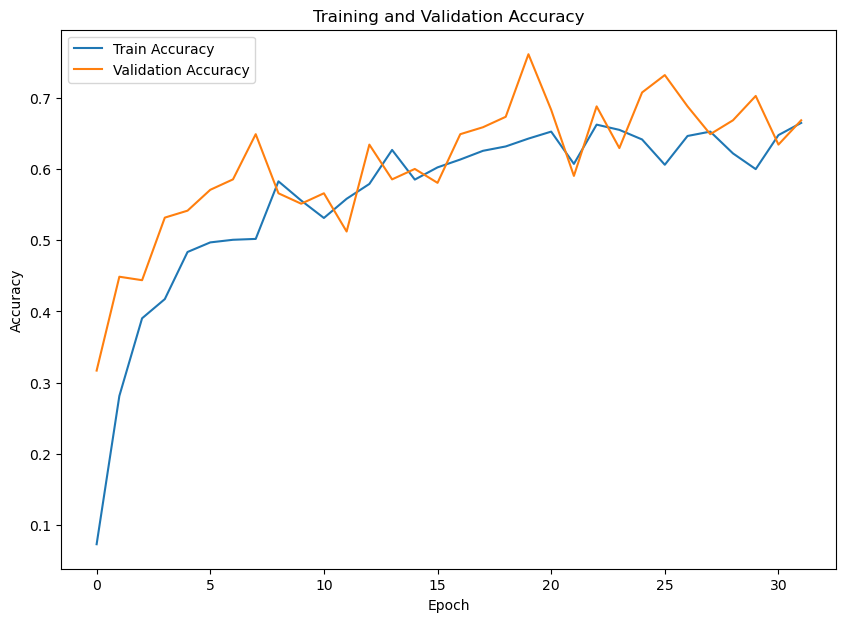

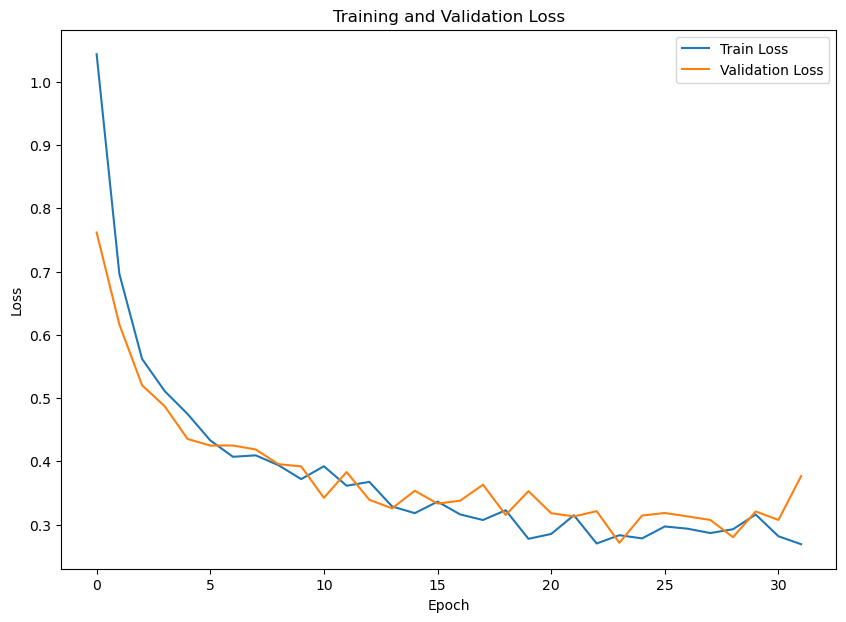

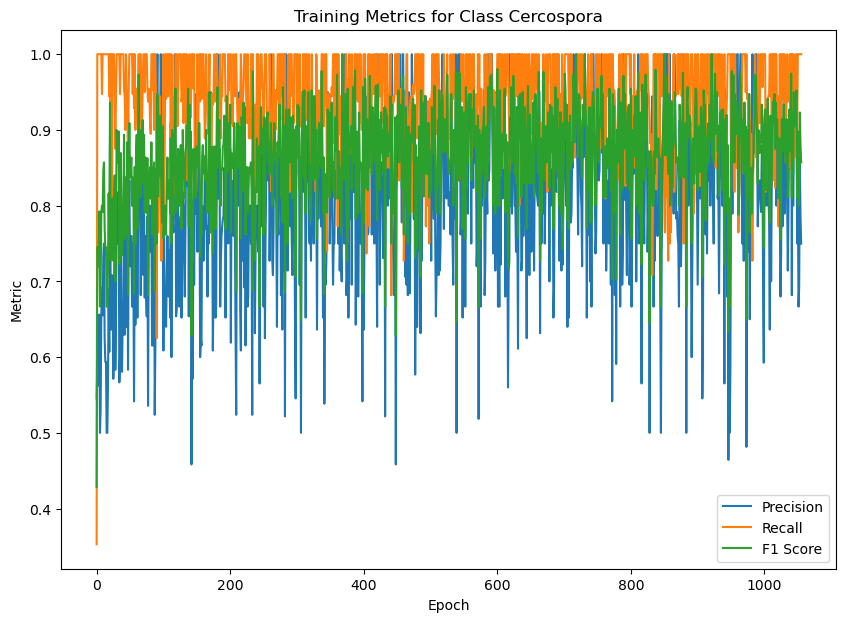

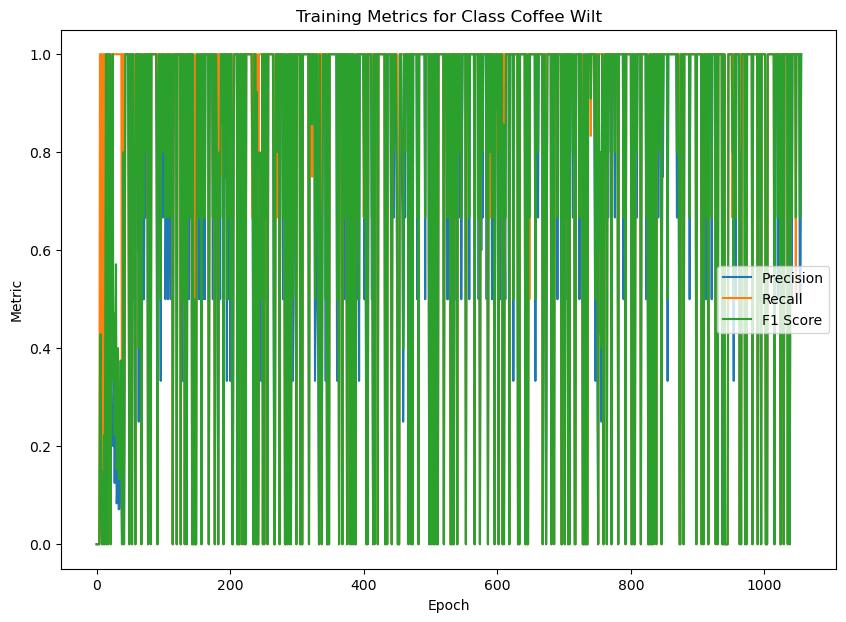

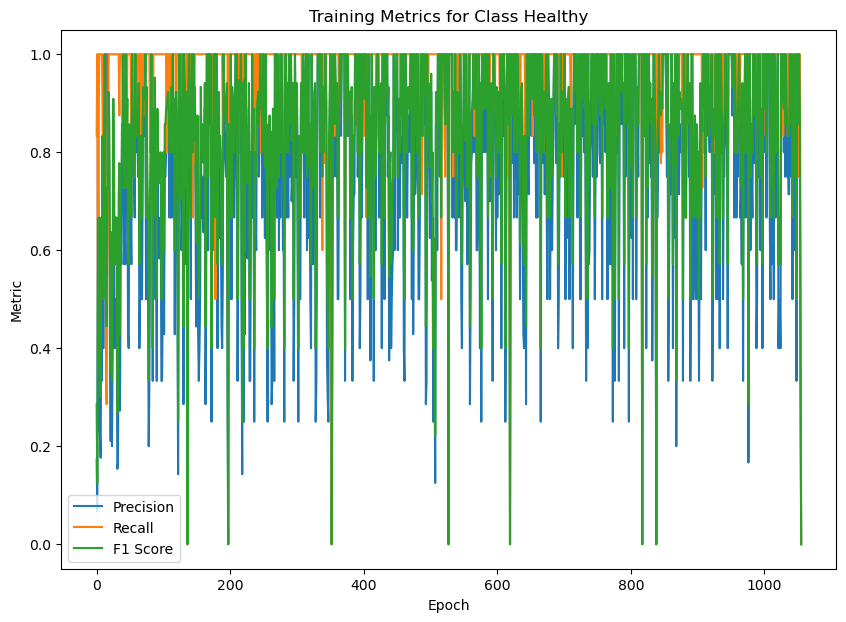

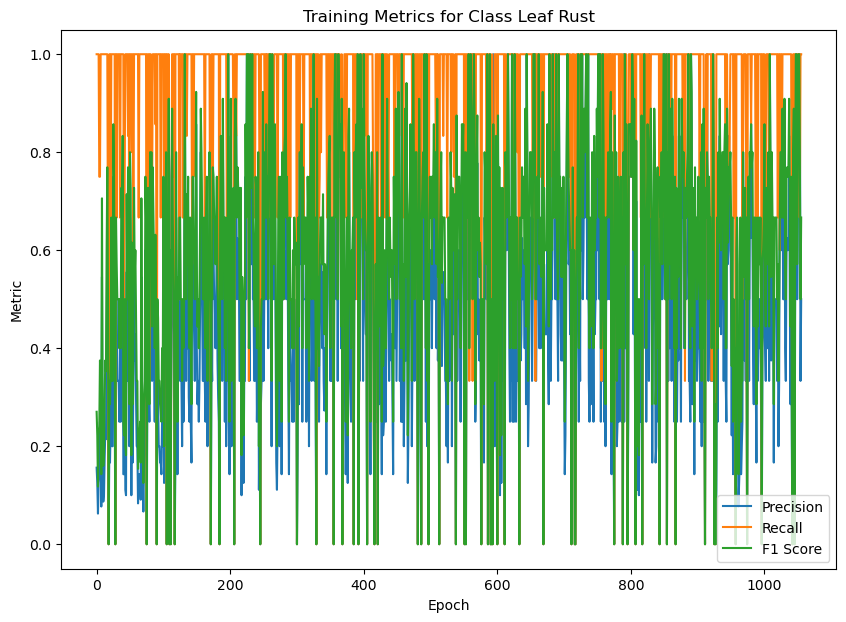

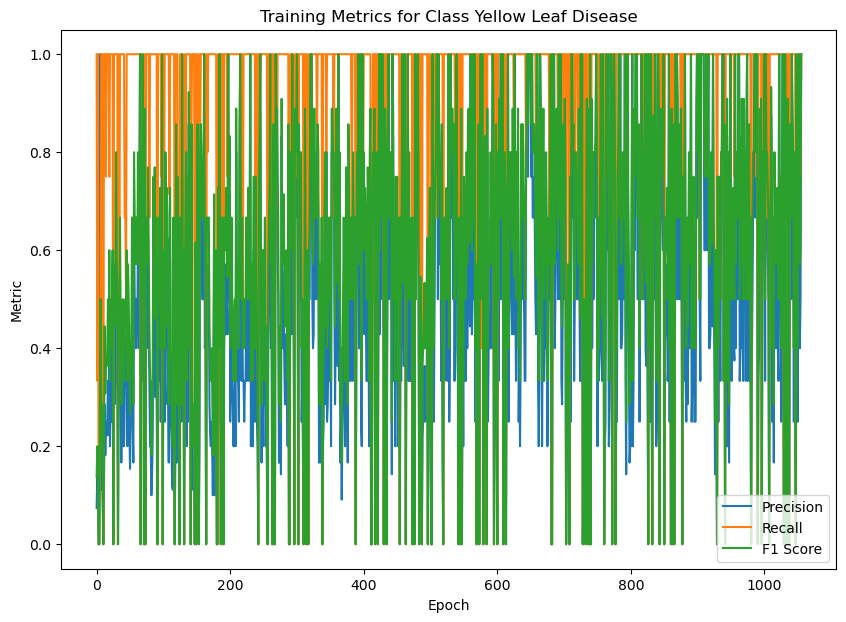

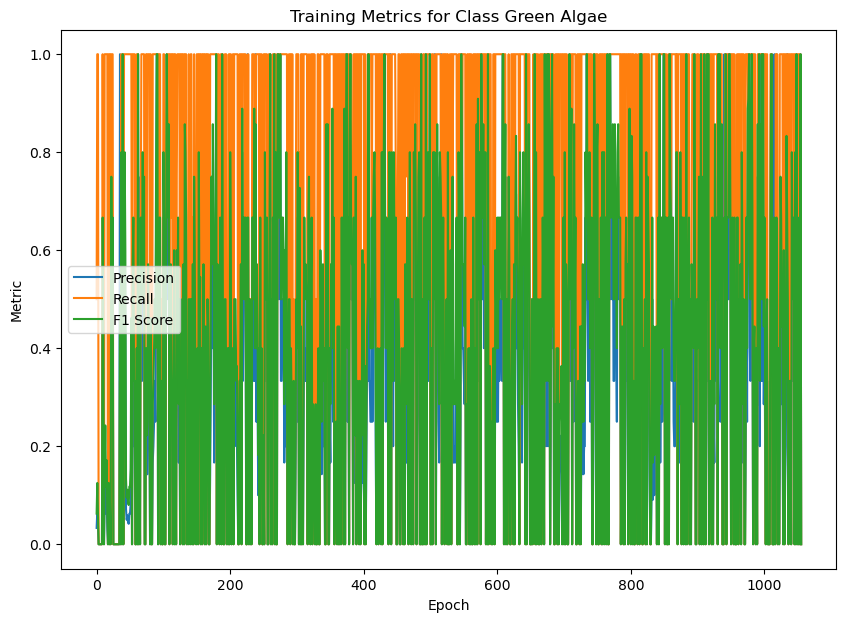

In [70]:
def train_model(model, criterion, optimizer, num_epochs=32, patience=6):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists for saving history
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # Initialize lists for saving precision, recall, and F1 score
    precision_history = [[] for _ in range(len(class_labels))]
    recall_history = [[] for _ in range(len(class_labels))]
    f1_score_history = [[] for _ in range(len(class_labels))]

    # Early stopping details
    early_stopping_counter = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.cuda()
                labels = labels.cuda().float() 

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Get the probabilities from the outputs
                    probs = torch.sigmoid(outputs)
                    # Apply a threshold of 0.5
                    preds = probs > 0.5
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate the number of correct predictions
                corrects = (preds == labels.byte()).all(1).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

                # Calculate metrics
                precision, recall, f1 = calculate_metrics(preds, labels)
                for i in range(len(class_labels)):
                    precision_history[i].append(precision[i])
                    recall_history[i].append(recall[i])
                    f1_score_history[i].append(f1[i])

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            # Check if early stopping conditions are met
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                            model.load_state_dict(best_model_wts)
                            break
                            
    time_elapsed = time.time() - since
    print('----------')
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Plot metrics
    def plot_metrics():
        # Plot accuracy
        plt.figure(figsize=(10, 7))
        plt.plot(train_acc_history, label='Train Accuracy')
        plt.plot(val_acc_history, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        # Plot loss
        plt.figure(figsize=(10, 7))
        plt.plot(train_loss_history, label='Train Loss')
        plt.plot(val_loss_history, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot precision, recall, and F1 score for each class
        for i in range(len(class_labels)):
            plt.figure(figsize=(10, 7))
            plt.plot(precision_history[i], label='Precision')
            plt.plot(recall_history[i], label='Recall')
            plt.plot(f1_score_history[i], label='F1 Score')
            plt.title(f'Training Metrics for Class {class_labels[i]}')
            plt.xlabel('Epoch')
            plt.ylabel('Metric')
            plt.legend()
            plt.show()

    plot_metrics()

    return model

model = train_model(model, criterion, optimizer, num_epochs=32, patience=6)

torch.save(model.state_dict(), 'model.pth')

def evaluate_model(model, criterion, data_loader):
    model.eval()  # set the model to evaluation mode

    running_loss = 0.0
    running_corrects = 0

    # Initialize lists for saving precision, recall, and F1 score
    precision_list = []
    recall_list = []
    f1_list = []

    for inputs, labels in data_loader:
        inputs = inputs.cuda()
        labels = labels.cuda().float()

        with torch.no_grad():  # deactivate autograd
            outputs = model(inputs)
            # Get the probabilities from the outputs
            probs = torch.sigmoid(outputs)
            # Apply a threshold of 0.5
            preds = probs > 0.5
            loss = criterion(outputs, labels)

        # Calculate the number of correct predictions
        corrects = (preds == labels.byte()).all(1).sum().item()
        running_corrects += corrects
        running_loss += loss.item() * inputs.size(0)

        # Calculate metrics
        precision, recall, f1 = calculate_metrics(preds, labels)
        precision_list.append(precision.mean())
        recall_list.append(recall.mean())
        f1_list.append(f1.mean())

    total_loss = running_loss / len(data_loader.dataset)
    total_acc = running_corrects / len(data_loader.dataset)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')
    print(f'Precision: {avg_precision:.2f} Recall: {avg_recall:.2f} F1 Score: {avg_f1:.2f}')

# Load the saved model
model.load_state_dict(torch.load('model.pth'))

# Evaluate the model on the test dataset
evaluate_model(model, criterion, test_loader)

In [72]:
# Initialize the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(class_labels) 
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved parameters
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
# Don't forget to set the model to evaluation mode if you're doing inference
model.eval()

# Define the prediction function
def predict_image(image_path, model, threshold=0.5):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        # Get the probabilities from the outputs
        probs = torch.sigmoid(output)
        # Apply a threshold
        preds = probs > threshold
        # Get the indices of the positive predictions
        positive_indices = [i for i, x in enumerate(preds[0]) if x]
        # Return the corresponding class labels
        return [class_labels[i] for i in positive_indices]

# Use the prediction function
image_path = "E:\Samples\CoffeeDisease_Samples\Cercospora\CLR (31).jpg"  
print("Predicted Class: ", predict_image(image_path, model))

Predicted Class:  ['Cercospora', 'Leaf Rust']
